In [1]:

%load_ext autoreload
%autoreload 2


In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "6"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']
#RUN BEFORE#

In [3]:
#RUN AFTER#

import hls4ml
import pickle
from time import time

from PionReconstruction.util.Models import *
from PionReconstruction.util.Generators import *
from PionReconstruction.util.Plotting import *


/home/joshualerner/projects/src/hls4ml/hls4ml/converters/__init__.py:25: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


In [4]:
#hls4ml.report.read_vivado_report('/fast_scratch_1/jlerner/GarNetHLS/c_128')

In [5]:
#hls4ml.report.read_vivado_report('/fast_scratch_1/jlerner/GarNetHLS/q_32')

In [6]:

data_path = '/fast_scratch_1/atlas_images/v01-45/'

cell_geo_path = data_path + 'cell_geo.root'

out_path = '/fast_scratch_1/jlerner/data/'

vmax = 32
quantized = True

if quantized:
    q = 'q'
else: 
    q = ''

In [7]:

model = tf.keras.models.load_model(out_path + f'models/{q}GarNet_log_{vmax}')

with open(out_path + f'models/{q}GarNet_log_{vmax}/history.pickle', "rb") as file:
    history = pickle.load(file)


2023-08-09 11:33:06.304534: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-08-09 11:33:06.304650: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9671 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:b1:00.0, compute capability: 7.5


In [8]:
name = f'garnet_log_{vmax}'

test_file_list = ([[data_path + f'pi0/user.angerami.24559740.OutputStream._000{i:03d}.root', 1] for i in range(232, 264)],
                  [[data_path + f'pipm/user.angerami.24559744.OutputStream._000{i:03d}.root', 0] for i in range(232, 264)])

test_generator = garnetDataGenerator(test_file_list,
                                     cell_geo_path,
                                     batch_size=20000,
                                     normalizer=('log', None),
                                     name=name,
                                     labeled=True,
                                     preprocess=False,
                                     output_dir=out_path + 'test/')

x, y = next(test_generator.generator())

In [9]:
# config = hls4ml.utils.config_from_keras_model(model, granularity='name')
# config
config = {'Model': {'Precision': 'ap_fixed<22, 10>', 'ReuseFactor': 1, 'Strategy': 'Latency'},
          'LayerName': {'data': {'Precision': {'result': 'ap_fixed<16, 6, AP_RND, AP_SAT>'}},
                        'vertex': {'Precision': {'result': 'ap_uint<16>'}},
                        'energy': {'Precision': {'result': 'ap_fixed<16, 6, AP_RND, AP_SAT>'}}},
          'Optimizers': ['eliminate_linear_activation']}

config['LayerType'] = {'InputLayer': {'ReuseFactor': 1, 'Trace': False},
                       'GarNetStack': {'ReuseFactor': 32, 'Trace': True}, 
                       'Dense': {'ReuseFactor': 1, 'Trace': True},
                       'Activation': {'ReuseFactor': 1, 'Trace': False}}

In [10]:
if quantized:
    q = 'q'
else:
    q = 'c'
hls_model = hls4ml.converters.convert_from_keras_model(model, hls_config=config, project_name=f'{q}_{vmax}',
                                                       output_dir=f'/fast_scratch_1/jlerner/GarNetHLS/{q}_{vmax}', 
                                                       part='xcu250-figd2104-2L-e')

Interpreting Model
Topology:
Layer name: data, layer type: InputLayer, input shapes: [[None, 32, 4]], output shape: [None, 32, 4]
Layer name: vertex, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: garnet, layer type: GarNetStack, input shapes: [[None, 32, 4], [None, 1]], output shape: [None, 16]
Layer name: energy, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: concatenate, layer type: Concatenate, input shapes: [[None, 16], [None, 1]], output shape: [None, 17]
Layer name: dense_1, layer type: Dense, input shapes: [[None, 17]], output shape: [None, 16]
Layer name: dense_2, layer type: Dense, input shapes: [[None, 16]], output shape: [None, 8]
Layer name: classification, layer type: Dense, input shapes: [[None, 8]], output shape: [None, 2]
Layer name: regression, layer type: Dense, input shapes: [[None, 8]], output shape: [None, 1]
Creating HLS model


In [11]:
hls_model.compile()
keras_pred = model.predict(x)
try:
    hls_pred = hls_model.predict(x)
except:
    hls_pred = None

Writing HLS project
Done


2023-08-09 11:33:29.130568: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


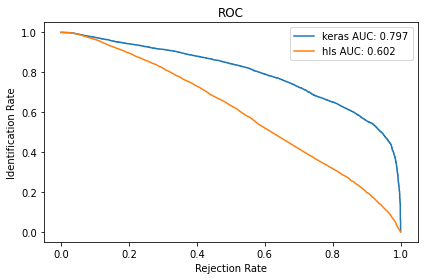

In [12]:
ROC = Plotter(roc, 
              preds=[keras_pred[0][:,0], hls_pred[0][:,0]],
              targets=[y['classification'][:,0], y['classification'][:,0]],
              labels=['keras', 'hls'])
ROC.show()

In [13]:
keras_scaled_pred = np.exp(keras_pred[-1]*10).reshape(-1,)
if hls_pred is not None:
    hls_scaled_pred = np.exp(hls_pred[-1]*10).reshape(-1,)
    scaled_target = np.exp(y['regression']*10).reshape(-1,)

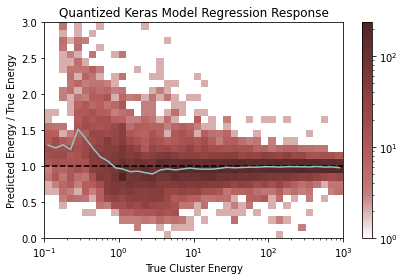

In [14]:

reg = Plotter(regResponse, 
              pred=keras_scaled_pred,
              target=scaled_target,
              stat=['median'],
              title='Quantized Keras Model Regression Response')

reg.show()

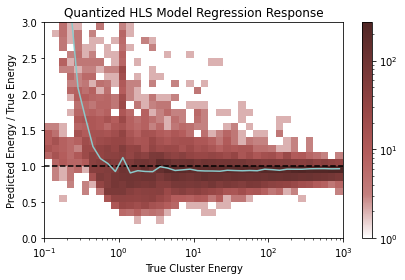

In [15]:

reg = Plotter(regResponse, 
              pred=hls_scaled_pred,
              target=scaled_target,
              stat=['median'],
              title='Quantized HLS Model Regression Response')

reg.show()

In [16]:

# reg = Plotter(regResponseOverlay, 
#               preds=[keras_scaled_pred, hls_scaled_pred], 
#               targets=[scaled_target, scaled_target],
#               stat=['mean', 'stdmean'],
#               labels=['keras', 'hls'])
# reg.show()

In [17]:
# prof = Plotter(weight_profile, model=model, hls_model=hls_model, x=x)
# prof.show()

In [18]:
# time_start = time
# hls_model.build(csim=False)
# print(time - time_start)